In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

2023-12-20 17:51:03.378829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 17:51:03.514211: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2023-12-20 17:51:04.308922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-20 17:51:04.308999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-20 17:51:04.309004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
    sess = tf.compat.v1.Session(config=config)

2023-12-20 15:28:19.289358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 15:28:20.273578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-20 15:28:20.295055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
import pickle

with open('./Pretraning_data/ZINC_10M_data','rb') as file:
    train = pickle.load(file)

In [4]:
train[1]

'O=C(NC(=O)c1cccc(F)c1)O[C@H]1CCS(=O)(=O)C1'

In [2]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles):
    res_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=4 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
    return res_list

In [7]:
len(train_1)

50100189

In [3]:
import tensorflow as tf

class MultiheadAttention_tensor(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,classical_rate = 0.25,Tensor_dimention = 20):
        super(MultiheadAttention_tensor, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.rate = classical_rate
        assert int(num_heads/classical_rate) == num_heads/classical_rate


        self.d_model = d_model
        self.wq = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wk = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wv = tf.keras.layers.Dense(int(d_model*classical_rate))

        self.wq_tensor = TNLayer(Tensor_dimention)
        self.wk_tensor = TNLayer(Tensor_dimention)
        self.wv_tensor = TNLayer(Tensor_dimention)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*self.rate), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def split_heads_tensor(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*(1-self.rate)), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, q, mask=None):
        batch_size = tf.shape(q)[0]
        k = q
        v = q
        q_class = self.split_heads(self.wq(q), batch_size)
        k_class = self.split_heads(self.wk(k), batch_size)
        v_class = self.split_heads(self.wv(v), batch_size)
        
        
        q_tensor = self.split_heads_tensor(self.wq_tensor(q),batch_size)
        k_tensor = self.split_heads_tensor(self.wq_tensor(k),batch_size)
        v_tensor = self.split_heads_tensor(self.wq_tensor(v),batch_size)
        q,k,v = tf.concat([q_class,q_tensor],axis=1),tf.concat([k_class,k_tensor],axis=1),tf.concat([v_class,v_tensor],axis=1)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf



def scheduler(epochs,lr):
    lr = 0.5*(1+np.cos(np.pi * epochs / 100))
    if epochs <= 5:
        lr *= epochs * 1.0 / 30
    return lr

class transformer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,ff_dim,name):
        super(transformer,self).__init__(name=name)
        self.attn = self_multihead(d_model,num_heads)
        self.ff = Sequential([Dense(ff_dim,activation='relu'),Dense(d_model)])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
    
    def call(self, inputs):
        attn_out = self.attn(inputs)
        out1 = self.norm1(inputs + attn_out)
        ffn_output = self.ff(out1)
        return self.norm2(out1 + ffn_output)

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        mask = self.token_emb.compute_mask(x)
        return x + positions
    

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TransformerBlock_Tensor(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiheadAttention_tensor(d_model=embed_dim,num_heads=num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output,_ = self.att(inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [5]:
from Module import custom_layers

In [6]:
BERT_tensor = custom_layers.BERT_tensor
TNLayer = custom_layers.TNLayer

In [7]:
A = TransformerBlock_Tensor(256,8,1024)
A(tf.random.normal([2,200,256]))

2023-12-20 17:51:15.993675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 17:51:16.643758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78900 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-20 17:51:18.541255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(2, 200, 256), dtype=float32, numpy=
array([[[-0.57521343,  0.9754174 , -0.6224187 , ..., -1.1204355 ,
         -0.42417064, -1.4144158 ],
        [-0.11509611, -0.366001  ,  0.62388223, ..., -0.21550858,
         -0.37314487,  2.2629604 ],
        [-0.12065608, -0.64267   ,  0.7685558 , ..., -0.37890434,
          0.6905878 ,  0.25933114],
        ...,
        [-1.1933622 , -0.26802015,  1.6054823 , ..., -0.78303516,
         -0.50591135, -1.1272988 ],
        [-1.3384835 , -1.0095831 ,  0.09122713, ..., -0.23975118,
         -0.7844407 ,  1.3783185 ],
        [-0.1596568 , -0.17068464, -0.02918897, ..., -1.5419705 ,
         -1.2477788 ,  1.490445  ]],

       [[ 1.1436063 , -1.2007061 ,  0.28502136, ..., -1.8840182 ,
         -1.6458308 , -1.5143496 ],
        [-1.0749815 , -1.4243169 , -0.3694662 , ...,  0.04623164,
          0.90865487, -0.57151026],
        [-0.46270764,  0.24913806,  0.7575609 , ..., -0.7935018 ,
         -1.054661  , -0.32611337],
        ...,

In [8]:
def replace_zeros_with_ones(input_tensor):
    # input_tensor에서 0인 값을 1로 바꾸는 연산
    modified_tensor = tf.where(tf.equal(input_tensor, 0), 1, input_tensor)
    return modified_tensor


def calculate_means(input_list, index_ranges):
    # TensorFlow 상수로 입력 리스트를 변환
    input_tensor = tf.constant(input_list)
    
    # 각각의 인덱스 범위를 나누어 평균 계산
    averages = [tf.reduce_mean(input_tensor[start:end]) for start, end in index_ranges]
    
    return averages


class Mask(tf.keras.layers.Layer):
    def __init__(self):
        super(Mask, self).__init__()
    def call(self, inputs,mask):
        prob = np.random.rand(1)[0]
        if prob<0.8:
            return tf.multiply(inputs,((mask-1)*(-1)))
        elif prob>=0.8:
            random_value = tf.random.uniform(shape=[inputs.shape[0]], minval=0, maxval=inputs.shape[1], dtype=tf.int32)
            random_value = mask*random_value[:,tf.newaxis]
            random_value = replace_zeros_with_ones(random_value)
            return tf.multiply(inputs,(random_value))
        else:
            return inputs




class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = tf.keras.layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

class BERT_tensor(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT_tensor, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock_Tensor(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(500,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [9]:
A = BERT_tensor(256,8,1024)
A(np.array([[1]+[0]*199]),None)

<tf.Tensor: shape=(1, 200, 256), dtype=float32, numpy=
array([[[-0.38977087,  0.8010836 , -0.1897599 , ..., -1.9751529 ,
         -1.494321  ,  0.42775318],
        [-0.5401098 ,  0.8480233 , -0.153665  , ..., -1.8392802 ,
         -1.4379914 ,  0.36432648],
        [-0.5556478 ,  0.92538977, -0.16529003, ..., -1.8228292 ,
         -1.3864769 ,  0.35592014],
        ...,
        [-0.4911892 ,  0.83580506, -0.15606998, ..., -1.9292316 ,
         -1.3535836 ,  0.35861784],
        [-0.41518012,  0.9466083 , -0.11745901, ..., -1.9303446 ,
         -1.3409542 ,  0.31543306],
        [-0.49056402,  0.91882694, -0.16103408, ..., -1.8821265 ,
         -1.3561776 ,  0.34452638]]], dtype=float32)>

In [10]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

In [11]:
from tdc.single_pred import Tox
from Module import RDK as rk
import atomInSmiles
from Module import Fine_tune

In [12]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 

train_set = []

def process_data(item):
    train_set.append(atomInSmiles.encode(item,True).split(' '))
    
    
if __name__ == '__main__':
    manager = Manager()
    train_set = manager.list(train_set)
    pool = Pool(60)
    pool.map(process_data, train_1)
    pool.close()
    pool.join()



Exception ignored in: <function _releaseLock at 0x7fca9e160940>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


NameError: name 'train_1' is not defined

In [15]:
from multiprocessing import Pool
from tqdm import tqdm
from multiprocessing import Process, Value, Array
from multiprocessing import Process,Manager,current_process
from Module import RDK as rk
import atomInSmiles 

train_set = []
def process_data(item):
    train_set.append(rk.smile_tokenize([item])[0])


if __name__ == '__main__':
    manager = Manager()
    train_set = manager.list(train_set)
    pool = Pool(60)
    pool.map(process_data, train)
    pool.close()
    pool.join()


In [13]:
temp = []

for i in tqdm(train_set):
    temp.append(i)
    
    
train_set = temp

100%|██████████| 50100189/50100189 [41:01<00:00, 20353.78it/s] 


Text(0, 0.5, 'counts')

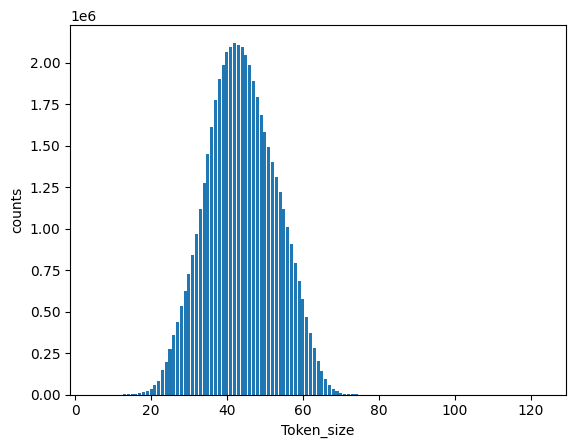

In [14]:
import matplotlib.pyplot as plt
length_list = {}


for index,i in enumerate(train_set):
    try:
        length_list[len(i)]=length_list[len(i)]+1
    except:
        length_list[len(i)] = 1
    
plt.bar(length_list.keys(),length_list.values())
plt.xlabel(xlabel='Token_size')
plt.ylabel('counts')    

In [15]:
temp_dict = {}
for i in train_set:
    for j in i:
        try:
            temp_dict[j] = temp_dict[j] + 1
        except:
            temp_dict[j] = 1
remove_dict = {}
for i in temp_dict.keys():
    if temp_dict[i]<50:
        print(i,temp_dict[i])
        remove_dict[i] = 1

remove_list = []
for index,i in enumerate(train_set):
    for j in i:
        try:
            remove_dict[j]
            remove_list.append(index)
            break
        except:
            continue

remove_list.sort(reverse=True)

[C;!R;CFN] 20
[CH2;!R;FO] 24
[C;!R;BrCClCl] 36
[P;R;CNN] 16
[Si;!R;CSiSiSi] 12
[C;!R;BrCF] 32
[c;R;NSSi] 24
[CH;!R;SSS] 36
[NH;R;NP] 16
[N;!R;OO] 4
[C;R;ClClSS] 24
[[N-];!R;ClS] 24
[S;R;CCC] 24
[N;!R;CSiSi] 16
[C;!R;BrBrCP] 8
[N;R;NOO] 4
[C;!R;BrBrBrS] 12
[O;!R;NN] 20
[n;R;BrCN] 4
[C;R;BrCCS] 20
[C;R;BrSSS] 4
[CH2;!R;FN] 16
[CH;!R;ClNN] 4
[N;!R;CCCl] 44
[n;R;COO] 8
[C;R;CFO] 12
[N;!R;OS] 48
[[N+];!R;CCN] 40
[c;R;CPS] 16
[c;R;CFO] 4
[n;R;BrCC] 16
[NH;!R;P] 12
[C;R;CFSS] 8
[N;R;CSiSi] 28
[Si;R;CNN] 32
[[NH+];R;CSiSi] 16
[n;R;COS] 48
[[NH2+];!R;S] 32
[CH;!R;CFP] 16
[Si;!R;CNNN] 12
[N;!R;CCSi] 28
[N;!R;PPP] 8
[C;R;SSSS] 12
[N;!R;CClCl] 12
[SH;R;CC] 48
[C;R;BrCSS] 20
[C;R;CClO] 4
[C;!R;OOP] 20
[C;!R;CFO] 44
[[PH+];R;NNN] 8
[[NH+];R;CCN] 16
[C;!R;CClClP] 20
[S;!R;CCOS] 16
[[N+];R;BrCCC] 12
[[N+];!R;PP] 12
[C;!R;CFPP] 16
[C;R;CClClS] 28
[[NH2+];!R;P] 4
[[NH+];!R;PP] 8
[O;!R;CCl] 16
[Cl;!R;O] 28
[[PH+];!R;NNN] 48
[P;!R;NNO] 8
[[NH2+];!R;CP] 8
[[PH+];!R;NNO] 28
[[N-];R;CP] 36
[C;!R;OOSi] 20
[CH

In [16]:
for i in remove_list:
    train_set.pop(i)
print(len(train_set))

50094160


In [13]:
import pickle
with open('./Pretraning_data/Random_ZINC_50M_ATM_tokken.pkl','rb') as file:
    train_set = pickle.load(file)

In [14]:
import pickle
molecule_dictionary = {'<start>':1,'<end>':2,'<unknown1>':3,'<unknown2>':4,'<unknown3>':5,'<unknow4>':6,'<unknown5>':7}

for molecule in train_set:
    for atom in molecule:
        try:
            molecule_dictionary[atom]
        except:
            molecule_dictionary[atom] = len(molecule_dictionary)+1
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    molecule_dictionary = pickle.load(file)
len(molecule_dictionary)

KeyboardInterrupt: 

In [15]:
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    molecule_dictionary = pickle.load(file)
len(molecule_dictionary)

732

In [16]:
from tqdm import tqdm
import numpy as np 

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
embedding_word = word_to_index(train_set,molecule_dictionary)   
embedding_word = np.array(embedding_word)

  0%|          | 106315/50094160 [00:01<14:16, 58386.94it/s]

100%|██████████| 50094160/50094160 [17:09<00:00, 48679.82it/s] 


In [17]:
from tdc.single_pred import Tox
from Module import RDK
import atomInSmiles

def word_to_index(train_set,dict):
    result = []
    for molecule in tqdm(train_set):
        temp_list = []
        temp_list.append(1)
        for atom in molecule:
            temp_list.append(dict[atom])
        while len(temp_list)!=200:
            temp_list.append(0)
        result.append(temp_list)
    return result
train_val,tox_info = Tox(name = 'AMES').get_data(format = 'DeepPurpose')
train_set_val = []

train_val = Chem_generator(train_val[:5000])


for i in train_val:
    train_set_val.append(atomInSmiles.encode(i,True).split(' '))
val_remove_list = []
for index,i in enumerate(train_set_val):
    for j in i:
        try:
            molecule_dictionary[j]
        except:
            val_remove_list.append(index)
            break
val_remove_list.sort(reverse=True)

for i in val_remove_list:
    train_set_val.pop(i)

embedding_word_val = word_to_index(train_set_val,molecule_dictionary)   
embedding_word_val = np.array(embedding_word_val)

Found local copy...
Loading...
Done!
100%|██████████| 19122/19122 [00:00<00:00, 69800.36it/s]


In [18]:
import random
max = 16
mask_input_val = []
for j in tqdm(train_set_val):
        value = []
        number = int(len(j)*0.15)
        if number>max:
                max = number
        if number == 0:
                number = 1
        value += random.sample(range(1,len(j)),number)
        mask_input_val.append(value)
        
        
for j in mask_input_val:
        while(len(j)<max):
                j.append(-1)


random_value_val = embedding_word_val.copy()        
for _,index in enumerate(mask_input_val):
        for j in index:
                if j != -1:
                        prob = np.random.rand(1)[0]
                        if prob < 0.8:
                                random_value_val[_][j] = 0
                        elif prob > 0.9:
                                temp1 = random.sample(range(0,301),1)[0]
                                random_value_val[_][j] = temp1
                                
output_val = tf.multiply(tf.reduce_sum(tf.one_hot(mask_input_val,200),axis=1),embedding_word_val)

100%|██████████| 19122/19122 [00:00<00:00, 265469.84it/s]

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
early_stopping_cb = EarlyStopping(patience=6, monitor='loss',restore_best_weights=True)

In [20]:
def custom_loss(y_true, y_pred):
    output = tf.one_hot(tf.cast(tf.boolean_mask(y_true,tf.cast(y_true,bool)),tf.int32),len(molecule_dictionary))
    loss = tf.keras.losses.CategoricalCrossentropy()(output,y_pred)
    return loss

In [21]:
def Custom_metric(y_true,y_pred):
    predictions = tf.argmax(y_pred,axis=1)
    true = tf.boolean_mask(y_true,tf.cast(y_true,bool))
    return  tf.metrics.Accuracy()(predictions,true)
def Mask_acc(y_true, y_pred):
    score = tf.py_function(func=Custom_metric, inp=[y_true, y_pred], Tout=tf.float32,  name='Custom_acc') 
    return score

In [22]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [23]:
def replace_zeros_with_ones(input_tensor):
    # input_tensor에서 0인 값을 1로 바꾸는 연산
    modified_tensor = tf.where(tf.equal(input_tensor, 0), 1, input_tensor)
    return modified_tensor


def calculate_means(input_list, index_ranges):
    # TensorFlow 상수로 입력 리스트를 변환
    input_tensor = tf.constant(input_list)
    
    # 각각의 인덱스 범위를 나누어 평균 계산
    averages = [tf.reduce_mean(input_tensor[start:end]) for start, end in index_ranges]
    
    return averages


class Mask(tf.keras.layers.Layer):
    def __init__(self):
        super(Mask, self).__init__()
    def call(self, inputs,mask):
        prob = np.random.rand(1)[0]
        if prob<0.8:
            return tf.multiply(inputs,((mask-1)*(-1)))
        elif prob>=0.8:
            random_value = tf.random.uniform(shape=[inputs.shape[0]], minval=0, maxval=inputs.shape[1], dtype=tf.int32)
            random_value = mask*random_value[:,tf.newaxis]
            random_value = replace_zeros_with_ones(random_value)
            return tf.multiply(inputs,(random_value))
        else:
            return inputs




class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(len(molecule_dictionary),activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

class BERT_tensor(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT_tensor, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock_Tensor(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(500,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        for i in range(8):
            hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [24]:
from Module import custom_layers

In [25]:
BERT_tensor = custom_layers.BERT_tensor

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf


import tensorflow as tf
import tensornetwork as tn
import numpy as np
import tensornetwork as tn
class TNLayer(tf.keras.layers.Layer):
    def __init__(self,Tensor_dimention = 20):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        

        self.A1 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A2 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A3 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A4 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,3], stddev=1.0/192.0), trainable=True)
        

        self.bias = tf.Variable(tf.zeros(shape=(192)), trainable=True)
        
    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using
        # tf.vectorized_map (see below).
        Nodes = [tn.Node(self.A1,'a0',backend="tensorflow")]
        Nodes+=[tn.Node(self.A2,f'a{1}',backend="tensorflow")]
        Nodes+=[tn.Node(self.A3,f'a{2}',backend="tensorflow")]
        Nodes+=[tn.Node(self.A4,f'a{3}',backend="tensorflow")]
        bias_var = self.bias
        input_vec = tf.reshape(inputs, [-1,200,4,4,4,4])
        T_node = tn.Node(input_vec, backend="tensorflow",name = 't')
        for i in range(len(Nodes)-1):
            if i == 0:
                Nodes[i][1]^Nodes[i+1][1]
            else:
                Nodes[i][2]^Nodes[i+1][1]
        for i in range(len(Nodes)):
            Nodes[i][0]^T_node[i+2]    
        contraction = T_node@Nodes[0]
        for i in range(1,len(Nodes)):
            contraction = contraction@Nodes[i]
        result = tf.reshape(contraction.tensor,[-1,200,192])
        result = result + bias_var
        return result


class TokenAndPositionEmbedding_mask(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,mask=False):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)
        self.positions = tf.range(start=1, limit=maxlen+1, delta=1)
    def call(self, x):
        positions = self.pos_emb(self.positions)
        mask = self.token_emb.compute_mask(x)
        x = self.token_emb(x)
        return x + positions,mask

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,mask=False):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)
        self.positions = tf.range(start=1, limit=maxlen+1, delta=1)
    def call(self, x):
        positions = self.pos_emb(self.positions)
        x = self.token_emb(x)
        return x + positions


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TransformerBlock_Tensor(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1,Tensor_dimention=20):
        super().__init__()
        self.att = MultiheadAttention_tensor(d_model=embed_dim,num_heads=num_heads,Tensor_dimention=Tensor_dimention)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs,mask=None):
        attn_output,_ = self.att(inputs,mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
import tensorflow as tf

class MultiheadAttention_tensor(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,classical_rate = 0.25,Tensor_dimention = 20):
        super(MultiheadAttention_tensor, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.rate = classical_rate
        assert int(num_heads/classical_rate) == num_heads/classical_rate


        self.d_model = d_model
        self.wq = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wk = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wv = tf.keras.layers.Dense(int(d_model*classical_rate))

        self.wq_tensor = TNLayer(Tensor_dimention)
        self.wk_tensor = TNLayer(Tensor_dimention)
        self.wv_tensor = TNLayer(Tensor_dimention)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*self.rate), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def split_heads_tensor(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*(1-self.rate)), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, q, mask=None):
        batch_size = tf.shape(q)[0]
        k = q
        v = q
        q_class = self.split_heads(self.wq(q), batch_size)
        k_class = self.split_heads(self.wk(k), batch_size)
        v_class = self.split_heads(self.wv(v), batch_size)
        
        
        q_tensor = self.split_heads_tensor(self.wq_tensor(q),batch_size)
        k_tensor = self.split_heads_tensor(self.wk_tensor(k),batch_size)
        v_tensor = self.split_heads_tensor(self.wv_tensor(v),batch_size)
        q,k,v = tf.concat([q_class,q_tensor],axis=1),tf.concat([k_class,k_tensor],axis=1),tf.concat([v_class,v_tensor],axis=1)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        scaled_attention_logits = tf.transpose(scaled_attention_logits,perm=[1,0,2,3])
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        scaled_attention_logits = tf.transpose(scaled_attention_logits,perm=[1,0,2,3])
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights
    
    
def Attention_mask(embedding_mask):
    embedding_mask = tf.logical_not(embedding_mask)
    embedding_mask = tf.cast(embedding_mask,tf.float32)
    embedding_mask = tf.expand_dims(embedding_mask,axis=-1)
    embedding_mask = tf.tile(embedding_mask,[1,1,200])
    embedding_mask = tf.transpose(embedding_mask,perm=[0,2,1])
    return embedding_mask

class BERT_tensor(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,CL_num = 3,Tensor_dimention=20):
        super(BERT_tensor, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock_Tensor(emb_dim,num_heads,ff_dim,Tensor_dimention=Tensor_dimention)
        self.embedding = TokenAndPositionEmbedding_mask(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(CL_num,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden,pad_mask = self.embedding(inputs)
        Att_mask = Attention_mask(pad_mask)
        for i in range(8):
            hidden = self.encoder(hidden,Att_mask)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden
        
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,CL_num = 3):
        super(BERT, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(CL_num,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        for i in range(8):
            hidden = self.embedding(inputs)
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,8,1024,732)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert (BERT)                    (None, 732)          1984942     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
Total params: 1,984,942
Trainable params: 1,984,942
Non-trainable params: 0
__________________

In [28]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.batch_count
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    self.batch_count += 1
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1000.) * tf.math.minimum(arg1, arg2)

In [60]:
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=400000):
        super(CustomLearningRateScheduler, self).__init__()
        self.warmup_steps = warmup_steps
        self.step = tf.Variable(0, trainable=False)

    def __call__(self, step):
        self.step.assign_add(1)  # 각 배치가 지나갈 때마다 step 증가
        lr = tf.cond(
            self.step <= self.warmup_steps,
            lambda: (1e-4 - 1e-6) / self.warmup_steps * tf.cast(self.step, tf.float32) + 1e-6,
            lambda: (1e-4) * (self.warmup_steps ** 0.5) / (tf.cast(self.step, tf.float32) ** 0.5)
        )
        return lr

In [61]:
lr = CustomLearningRateScheduler()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)

In [62]:
#model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')

In [63]:

import random
size = 500000
for k in range(1):
        lr = CustomLearningRateScheduler()
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i+12
                """
                if i == int(len(embedding_word)/size):
                        break
                if i+50 <80:
                        lr = (1e-4-1e-6)*(i)/80 + 1e-6
                else:
                        lr = 1e-4*np.sqrt(80)/np.sqrt(i)"""
                lr = CustomLearningRateScheduler()
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
                model.compile(optimizer= optimizer, loss = custom_loss, metrics= Mask_acc)
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                number = max
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,len(molecule_dictionary)),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        if i % 20 == 0:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb],validation_data=([np.array(random_value_val),np.array(mask_input_val)],np.array(output_val)))
                        else:
                                model.fit([np.array(random_value),np.array(inputs2)],np.array(output,dtype = int),epochs=1,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights')

 36%|███▌      | 180098/500000 [00:01<00:01, 185330.39it/s]

100%|██████████| 500000/500000 [00:02<00:00, 187501.89it/s]


This is 0 number step
1954/1954 [==============================] - 400s 196ms/step - loss: 3.1160 - Mask_acc: 0.2561 - val_loss: 3.3571 - val_Mask_acc: 0.2450
<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=1.4838624e-06>


100%|██████████| 500000/500000 [00:02<00:00, 184625.76it/s]


This is 1 number step
 977/1954 [==============>...............] - ETA: 3:08 - loss: 3.1199 - Mask_acc: 0.2556

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf


import tensorflow as tf
import tensornetwork as tn
import numpy as np
import tensornetwork as tn
class TNLayer(tf.keras.layers.Layer):
    def __init__(self,Tensor_dimention = 20):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        

        self.A1 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A2 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A3 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,Tensor_dimention,4], stddev=1.0/192.0), trainable=True)
        self.A4 = tf.Variable(tf.random.normal(shape=[4,Tensor_dimention,3], stddev=1.0/192.0), trainable=True)
        

        self.bias = tf.Variable(tf.zeros(shape=(192)), trainable=True)
        
    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using
        # tf.vectorized_map (see below).
        Nodes = [tn.Node(self.A1,'a0',backend="tensorflow")]
        Nodes+=[tn.Node(self.A2,f'a{1}',backend="tensorflow")]
        Nodes+=[tn.Node(self.A3,f'a{2}',backend="tensorflow")]
        Nodes+=[tn.Node(self.A4,f'a{3}',backend="tensorflow")]
        bias_var = self.bias
        input_vec = tf.reshape(inputs, [-1,200,4,4,4,4])
        T_node = tn.Node(input_vec, backend="tensorflow",name = 't')
        for i in range(len(Nodes)-1):
            if i == 0:
                Nodes[i][1]^Nodes[i+1][1]
            else:
                Nodes[i][2]^Nodes[i+1][1]
        for i in range(len(Nodes)):
            Nodes[i][0]^T_node[i+2]    
        contraction = T_node@Nodes[0]
        for i in range(1,len(Nodes)):
            contraction = contraction@Nodes[i]
        result = tf.reshape(contraction.tensor,[-1,200,192])
        result = result + bias_var
        return result


class TokenAndPositionEmbedding_mask(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,mask=False):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)
        self.positions = tf.range(start=1, limit=maxlen+1, delta=1)
    def call(self, x):
        positions = self.pos_emb(self.positions)
        mask = self.token_emb.compute_mask(x)
        x = self.token_emb(x)
        return x + positions,mask

class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,mask=False):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)
        self.positions = tf.range(start=1, limit=maxlen+1, delta=1)
    def call(self, x):
        positions = self.pos_emb(self.positions)
        x = self.token_emb(x)
        return x + positions


class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads,kernel_regularizer=l2_reg,dropout=0.1)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TransformerBlock_Tensor(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1,Tensor_dimention=20):
        super().__init__()
        self.att = MultiheadAttention_tensor(d_model=embed_dim,num_heads=num_heads,Tensor_dimention=Tensor_dimention)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs,mask=None):
        attn_output,_ = self.att(inputs,mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
import tensorflow as tf

class MultiheadAttention_tensor(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,classical_rate = 0.25,Tensor_dimention = 20):
        super(MultiheadAttention_tensor, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.rate = classical_rate
        assert int(num_heads/classical_rate) == num_heads/classical_rate


        self.d_model = d_model
        self.wq = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wk = tf.keras.layers.Dense(int(d_model*classical_rate))
        self.wv = tf.keras.layers.Dense(int(d_model*classical_rate))

        self.wq_tensor = TNLayer(Tensor_dimention)
        self.wk_tensor = TNLayer(Tensor_dimention)
        self.wv_tensor = TNLayer(Tensor_dimention)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*self.rate), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def split_heads_tensor(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, int(self.num_heads*(1-self.rate)), self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, q, mask=None):
        batch_size = tf.shape(q)[0]
        k = q
        v = q
        q_class = self.split_heads(self.wq(q), batch_size)
        k_class = self.split_heads(self.wk(k), batch_size)
        v_class = self.split_heads(self.wv(v), batch_size)
        
        
        q_tensor = self.split_heads_tensor(self.wq_tensor(q),batch_size)
        k_tensor = self.split_heads_tensor(self.wk_tensor(k),batch_size)
        v_tensor = self.split_heads_tensor(self.wv_tensor(v),batch_size)
        q,k,v = tf.concat([q_class,q_tensor],axis=1),tf.concat([k_class,k_tensor],axis=1),tf.concat([v_class,v_tensor],axis=1)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        scaled_attention_logits = tf.transpose(scaled_attention_logits,perm=[1,0,2,3])
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        scaled_attention_logits = tf.transpose(scaled_attention_logits,perm=[1,0,2,3])
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights
    
    
def Attention_mask(embedding_mask):
    embedding_mask = tf.logical_not(embedding_mask)
    embedding_mask = tf.cast(embedding_mask,tf.float32)
    embedding_mask = tf.expand_dims(embedding_mask,axis=-1)
    embedding_mask = tf.tile(embedding_mask,[1,1,200])
    embedding_mask = tf.transpose(embedding_mask,perm=[0,2,1])
    return embedding_mask

class BERT_tensor(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,CL_num = 3,Tensor_dimention=20):
        super(BERT_tensor, self).__init__()
        #self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        self.encoder = TransformerBlock_Tensor(emb_dim,num_heads,ff_dim,Tensor_dimention=Tensor_dimention)
        self.embedding = TokenAndPositionEmbedding_mask(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(CL_num,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden,pad_mask = self.embedding(inputs)
        Att_mask = Attention_mask(pad_mask)
        for i in range(8):
            hidden = self.encoder(hidden,Att_mask)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden
        
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,CL_num = 3):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        #self.encoder = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(CL_num,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
            
        hidden = self.embedding(inputs)
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [36]:
temp_weights = model.get_weights()

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Embedding
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,8,1024,732)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()
optmizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optmizer,loss = custom_loss,metrics = Mask_acc)
all_weights = temp_weights[:16]*8 + temp_weights[16:]
model.set_weights(all_weights)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert_1 (BERT)                  (None, 732)          7513262     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
Total params: 7,513,262
Trainable params: 7,513,262
Non-trainable params: 0
________________

In [40]:
import random
size = 100000
for k in range(1,11):
        for i in range(0,int(len(embedding_word)/size)):
                if k == 1:
                        i = i
                if i == int(len(embedding_word)/size):
                        break
                
                max = 16
                mask_input = []
                for j in tqdm(train_set[size*i:size*(i+1)]):
                        value = []
                        number = int(len(j)*0.15)
                        if number>max:
                                max = number
                        if number == 0:
                                number = 1
                        value += random.sample(range(1,len(j)),number)
                        mask_input.append(value)
                        
                        
                for j in mask_input:
                        while(len(j)<max):
                                j.append(-1)
                
                
                
                
                
                
                inputs1 = embedding_word[size*i:size*(i+1)]
                inputs2 = mask_input
                output = tf.multiply(tf.reduce_sum(tf.one_hot(inputs2,200),axis=1),inputs1)

                
                random_value = inputs1.copy()        
                for _,index in enumerate(inputs2):
                        for j in index:
                                if j != -1:
                                        prob = np.random.rand(1)[0]
                                        if prob < 0.8:
                                                random_value[_][j] = 0
                                        elif prob > 0.9:
                                                temp1 = random.sample(range(0,301),1)[0]
                                                random_value[_][j] = temp1
                                                
                
                
                print(f'This is {i} number step')
                with tf.device('/device:GPU:0'):
                        model.fit([np.array(random_value),np.array(inputs2)],np.array(output),epochs=20,batch_size=256,callbacks = [early_stopping_cb])
                        print(model.optimizer.lr)
                        model.save_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights')

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:00<00:00, 225264.29it/s]


This is 0 number step
Epoch 1/20


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
from tdc.utils import retrieve_label_name_list
from tdc.single_pred import Tox
from Models.BERT import BERT_train
from Models.BERT import BERT_train_pre
from Module.Fine_tunning import fine_tuning

tox = ['hERG','hERG_Karim','AMES','DILI','Skin Reaction','Carcinogens_Lagunin','ToxCast','herg_central']
train = []
for i in tox:
    try:
        label_list = retrieve_label_name_list(i)
        temp,_ = Tox(name = i, label_name = label_list[0]).get_data(format = 'DeepPurpose')
        for j in temp:
            train.append(j)
    except:
        temp,_ = Tox(name = i).get_data(format = 'DeepPurpose')
        for j in temp:
            train.append(j)



2023-12-03 11:35:59.895014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 11:36:01.559818: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 11:36:06.135418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-03 11:36:06.135748: W te

In [ ]:
config = {'Tox':'ALL_TOX'}
BERT_model = BERT_train_pre("./BERT/SmiletoPE/L_model_weights.h5",3500)
fine_tuning(BERT_model,train,config)
BERT_model.save_weights(f"./BERT/SmiletoPE/Fine_tunned/ALL_TOX.h5")

100%|██████████| 331161/331161 [00:05<00:00, 61684.62it/s]


Epoch 1/40
1294/1294 [==============================] - 476s 364ms/step - loss: 5.2171 - Mask_acc: 0.2770
Epoch 2/40
1294/1294 [==============================] - 470s 363ms/step - loss: 4.6796 - Mask_acc: 0.3057
Epoch 3/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.5581 - Mask_acc: 0.3100
Epoch 4/40
1294/1294 [==============================] - 470s 363ms/step - loss: 4.4853 - Mask_acc: 0.3127
Epoch 5/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.4342 - Mask_acc: 0.3150
Epoch 6/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.3795 - Mask_acc: 0.3178
Epoch 7/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.2972 - Mask_acc: 0.3229
Epoch 8/40
1294/1294 [==============================] - 469s 362ms/step - loss: 4.1827 - Mask_acc: 0.3283
Epoch 9/40
1294/1294 [==============================] - 469s 363ms/step - loss: 4.0443 - Mask_acc: 0.3341
Epoch 10/40
1294/1294 [=======================

In [ ]:
import tensorflow as tf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(1e-4) * tf.math.minimum(arg1, arg2)



import tensorflow as tf
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+1)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return 1 * tf.math.minimum(arg1, arg2)
import matplotlib.pyplot as plt
temp_learning_rate_schedule = CustomSchedule(256,10000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='loss',   # loss 값을 모니터링합니다.
    factor=0.2,       # 학습률을 줄이는 비율입니다.
    patience=5,       # 개선이 없을 때 몇 번의 에포크를 기다릴지 설정합니다.
    min_lr=1e-6       # 최소 학습률입니다. 
)


In [5]:
temp_learning_rate_schedule(1)

<tf.Tensor: shape=(), dtype=float32, numpy=2e-06>

In [6]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_loss):
        super(CustomCallback, self).__init__()
        self.target_loss = target_loss

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and logs.get('loss') <= self.target_loss:
            print(f"\nReached target loss ({self.target_loss}). Stopping training.")
            self.model.stop_training = True
target_loss_value = 0.1  # 여기에 원하는 loss 값 설정
custom_callback = CustomCallback(target_loss_value)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_8 (Dense)             (None, 250)               512250    
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_9 (Dense)             (None, 40)                10040     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                410       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0   

Found local copy...
Loading...
Done!


Deleted sentences : 901
Sentences :  216
['<unknown1>', '<start>', 'Oc1ccc(', 'CCN2', 'CCC(N', 'c3nc4ccccc4', 'n3', 'C', 'c3ccc(F)cc3)', 'CC2)cc1', '<end>']
Epoch 1/300
6/6 [==============================] - 9s 411ms/step - loss: 0.9365 - acc: 0.3430 - auc: 0.5660 - val_loss: 0.9618 - val_acc: 0.2727 - val_auc: 0.3268 - lr: 1.0000e-06
Epoch 2/300
6/6 [==============================] - 1s 256ms/step - loss: 0.9473 - acc: 0.3256 - auc: 0.5098 - val_loss: 0.9521 - val_acc: 0.2727 - val_auc: 0.4062 - lr: 2.0000e-06
Epoch 3/300
6/6 [==============================] - 1s 188ms/step - loss: 0.9451 - acc: 0.3198 - auc: 0.4452 - val_loss: 0.9377 - val_acc: 0.2273 - val_auc: 0.4258 - lr: 3.0000e-06
Epoch 4/300
6/6 [==============================] - 1s 262ms/step - loss: 0.8957 - acc: 0.3663 - auc: 0.5237 - val_loss: 0.9133 - val_acc: 0.2273 - val_auc: 0.4023 - lr: 4.0000e-06
Epoch 5/300
6/6 [==============================] - 1s 168ms/step - loss: 0.8657 - acc: 0.4186 - auc: 0.4869 - val_loss: 0.8

6/6 [==============================] - 1s 139ms/step - loss: 0.6833 - acc: 0.7267 - auc: 0.5277 - val_loss: 0.6782 - val_acc: 0.7273 - val_auc: 0.6302 - lr: 2.8000e-05
Epoch 29/300
6/6 [==============================] - 1s 134ms/step - loss: 0.6781 - acc: 0.7267 - auc: 0.5414 - val_loss: 0.6766 - val_acc: 0.7273 - val_auc: 0.6875 - lr: 2.9000e-05
Epoch 30/300
6/6 [==============================] - 1s 102ms/step - loss: 0.6780 - acc: 0.7267 - auc: 0.5381 - val_loss: 0.6752 - val_acc: 0.7273 - val_auc: 0.6328 - lr: 3.0000e-05
Epoch 31/300
6/6 [==============================] - 1s 99ms/step - loss: 0.6838 - acc: 0.7267 - auc: 0.5461 - val_loss: 0.6731 - val_acc: 0.7273 - val_auc: 0.6641 - lr: 3.1000e-05
Epoch 32/300
6/6 [==============================] - 1s 101ms/step - loss: 0.6690 - acc: 0.7267 - auc: 0.5613 - val_loss: 0.6707 - val_acc: 0.7273 - val_auc: 0.6823 - lr: 3.2000e-05
Epoch 33/300
6/6 [==============================] - 1s 100ms/step - loss: 0.6751 - acc: 0.7267 - auc: 0.5391 

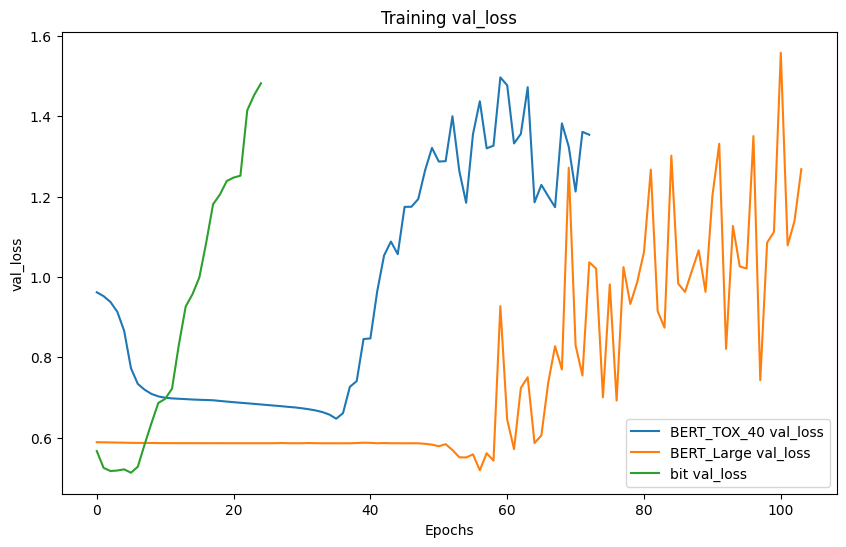

Tox :  herg


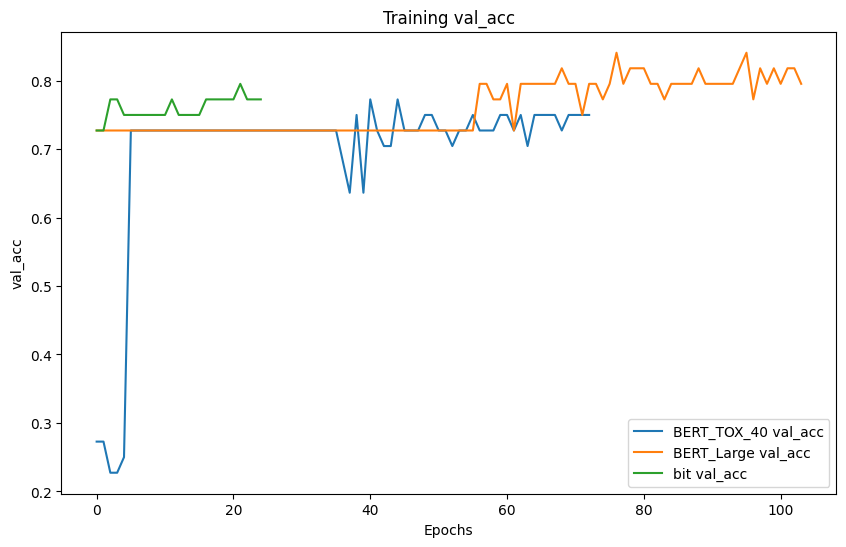

Tox :  herg


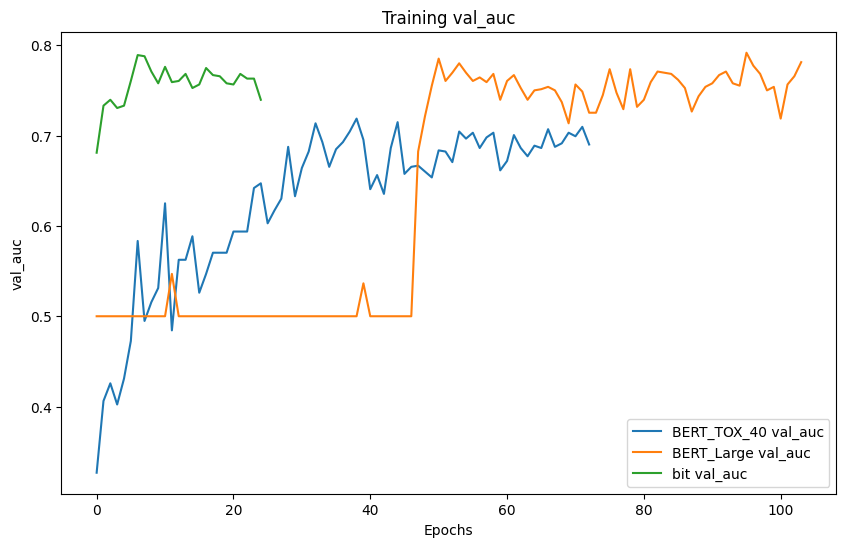

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_32 (Dense)            (None, 250)               512250    
                                                                 
 dropout_15 (Dropout)        (None, 250)               0         
                                                                 
 dense_33 (Dense)            (None, 40)                10040     
                                                                 
 dropout_16 (Dropout)        (None, 40)                0         
                                                                 
 dense_34 (Dense)            (None, 10)                410       
                                                                 
 dropout_17 (Dropout)        (None, 10)                0   

Found local copy...
Loading...
Done!


Deleted sentences : 821
Sentences :  6557
['<unknown1>', '<start>', 'O=[N+]([O-])', 'c1cc', 'c2cc', 'c3ccc(', '[N+](=O)[O-])', 'c4', 'c5ccccc5', 'c1', 'c2c3', '4', '<end>']
Epoch 1/300
164/164 [==============================] - 27s 127ms/step - loss: 0.8198 - acc: 0.5550 - auc: 0.5159 - val_loss: 0.8035 - val_acc: 0.5587 - val_auc: 0.5921 - lr: 1.0000e-06
Epoch 2/300
164/164 [==============================] - 14s 88ms/step - loss: 0.8075 - acc: 0.5453 - auc: 0.5117 - val_loss: 0.7954 - val_acc: 0.5587 - val_auc: 0.5027 - lr: 2.0000e-06
Epoch 3/300
164/164 [==============================] - 13s 80ms/step - loss: 0.8048 - acc: 0.5396 - auc: 0.5017 - val_loss: 0.7915 - val_acc: 0.5587 - val_auc: 0.4944 - lr: 3.0000e-06
Epoch 4/300
164/164 [==============================] - 13s 79ms/step - loss: 0.7976 - acc: 0.5451 - auc: 0.5047 - val_loss: 0.7869 - val_acc: 0.5587 - val_auc: 0.5193 - lr: 4.0000e-06
Epoch 5/300
164/164 [==============================] - 13s 81ms/step - loss: 0.7934 - acc:

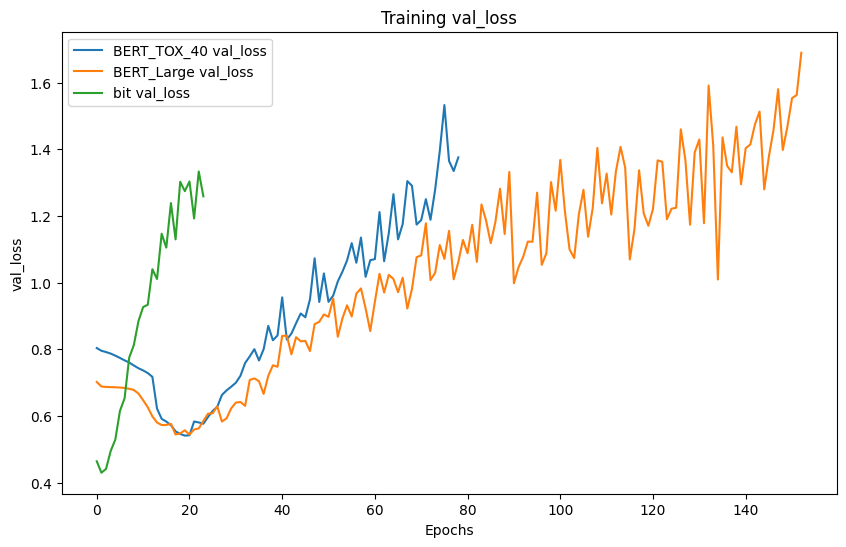

Tox :  AMES


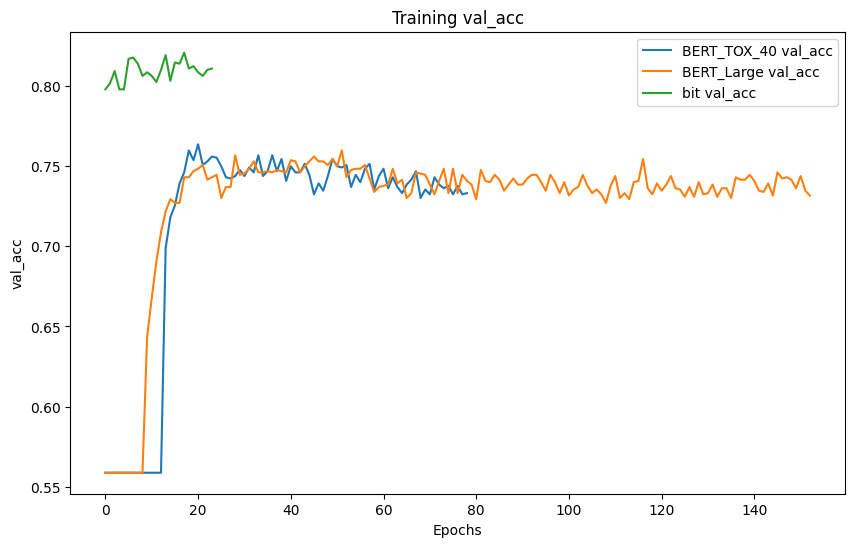

Tox :  AMES


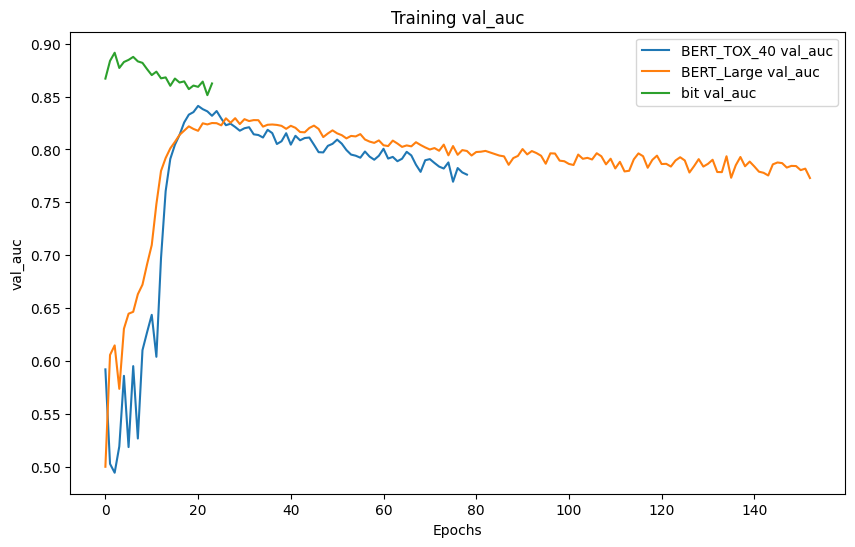

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_56 (Dense)            (None, 250)               512250    
                                                                 
 dropout_26 (Dropout)        (None, 250)               0         
                                                                 
 dense_57 (Dense)            (None, 40)                10040     
                                                                 
 dropout_27 (Dropout)        (None, 40)                0         
                                                                 
 dense_58 (Dense)            (None, 10)                410       
                                                                 
 dropout_28 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 404
Sentences :  13060
['<unknown1>', '<start>', 'Fc1ccc(', '-n2', 'cc(N', 'CCN3', 'CCCCC3)', 'nn2)cc1', 'F', '<end>']
Epoch 1/300
327/327 [==============================] - 44s 115ms/step - loss: 0.8167 - acc: 0.5022 - auc: 0.5660 - val_loss: 0.8052 - val_acc: 0.4939 - val_auc: 0.4985 - lr: 1.0000e-06
Epoch 2/300
327/327 [==============================] - 28s 85ms/step - loss: 0.8082 - acc: 0.5031 - auc: 0.5010 - val_loss: 0.7977 - val_acc: 0.5038 - val_auc: 0.5051 - lr: 2.0000e-06
Epoch 3/300
327/327 [==============================] - 27s 84ms/step - loss: 0.7977 - acc: 0.5062 - auc: 0.5075 - val_loss: 0.7876 - val_acc: 0.5038 - val_auc: 0.5022 - lr: 3.0000e-06
Epoch 4/300
327/327 [==============================] - 28s 85ms/step - loss: 0.7868 - acc: 0.5033 - auc: 0.5018 - val_loss: 0.7757 - val_acc: 0.5038 - val_auc: 0.5002 - lr: 4.0000e-06
Epoch 5/300
327/327 [==============================] - 28s 84ms/step - loss: 0.7751 - acc: 0.5048 - auc: 0.5003 - val_loss: 

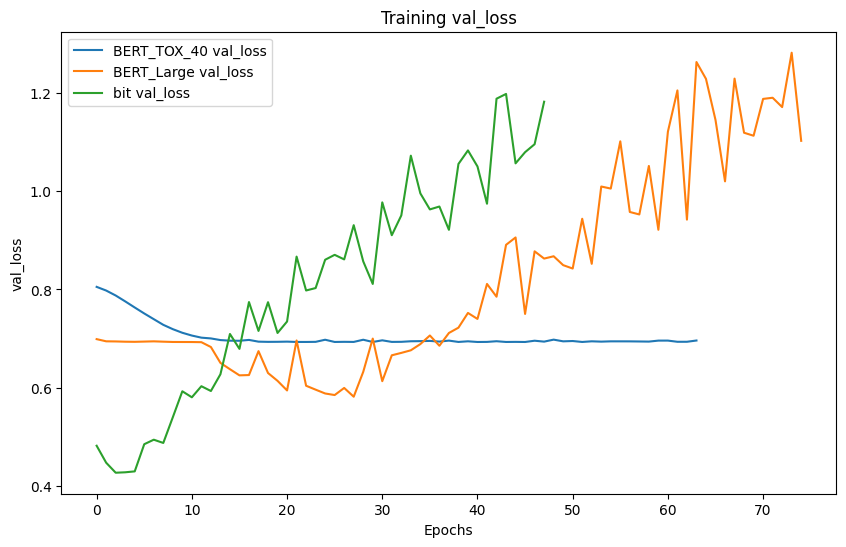

Tox :  herg_Karim


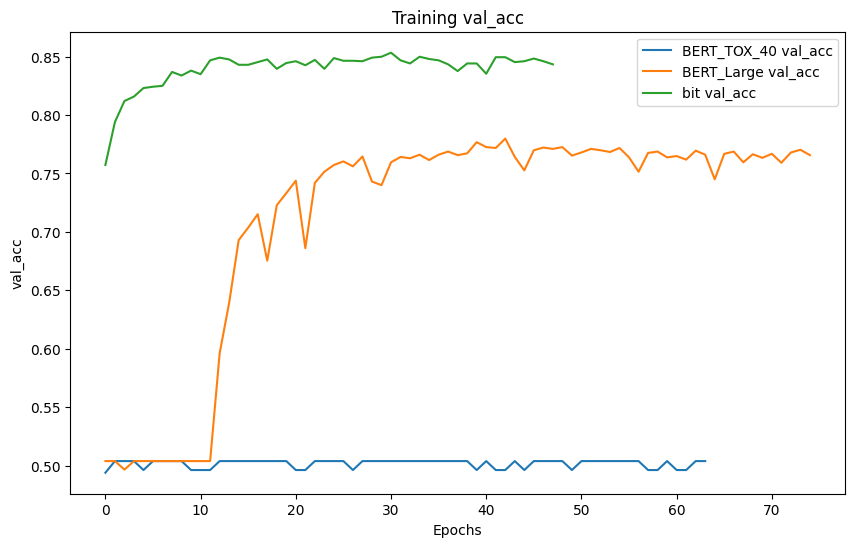

Tox :  herg_Karim


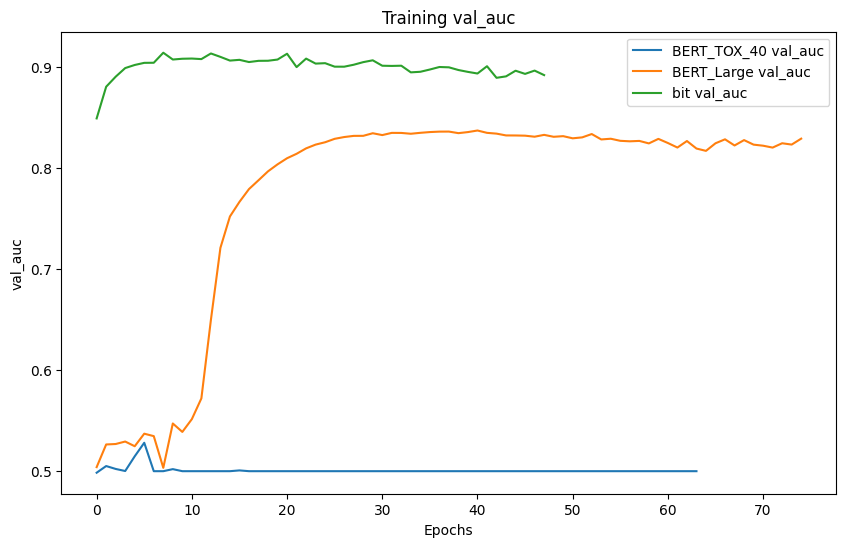

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_80 (Dense)            (None, 250)               512250    
                                                                 
 dropout_37 (Dropout)        (None, 250)               0         
                                                                 
 dense_81 (Dense)            (None, 40)                10040     
                                                                 
 dropout_38 (Dropout)        (None, 40)                0         
                                                                 
 dense_82 (Dense)            (None, 10)                410       
                                                                 
 dropout_39 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 806
Sentences :  103
['<unknown1>', '<start>', 'C', '[N+](C)(C)', 'CC(=O)', '[O-]', '<end>']
Epoch 1/300
3/3 [==============================] - 8s 750ms/step - loss: 0.6491 - acc: 0.7927 - auc: 0.8902 - val_loss: 0.6664 - val_acc: 0.7619 - val_auc: 0.5000 - lr: 1.0000e-06
Epoch 2/300
3/3 [==============================] - 1s 202ms/step - loss: 0.6365 - acc: 0.7927 - auc: 0.5724 - val_loss: 0.6663 - val_acc: 0.7619 - val_auc: 0.5000 - lr: 2.0000e-06
Epoch 3/300
3/3 [==============================] - 0s 178ms/step - loss: 0.6358 - acc: 0.7927 - auc: 0.5729 - val_loss: 0.6662 - val_acc: 0.7619 - val_auc: 0.3625 - lr: 3.0000e-06
Epoch 4/300
3/3 [==============================] - 1s 221ms/step - loss: 0.6334 - acc: 0.7927 - auc: 0.5190 - val_loss: 0.6663 - val_acc: 0.7619 - val_auc: 0.2562 - lr: 4.0000e-06
Epoch 5/300
3/3 [==============================] - 1s 206ms/step - loss: 0.6472 - acc: 0.7927 - auc: 0.4774 - val_loss: 0.6660 - val_acc: 0.7619 - val_auc: 0.3000 - lr

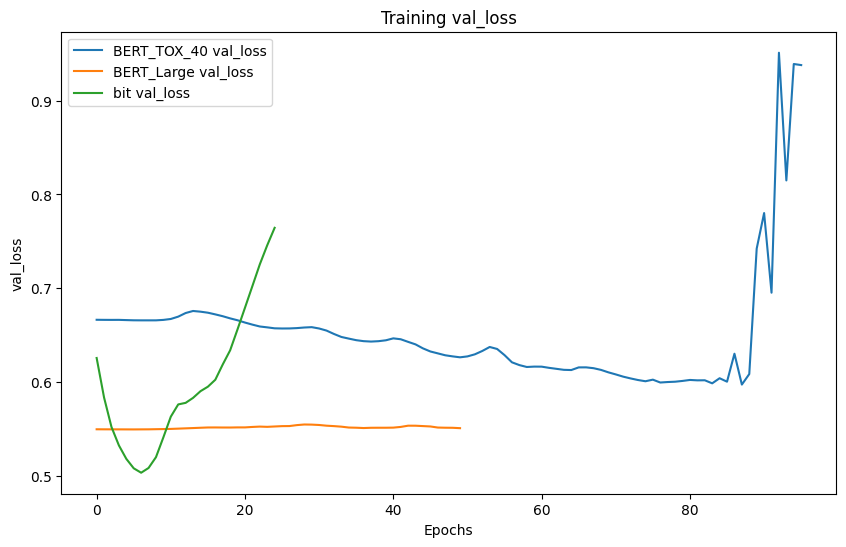

Tox :  DILI


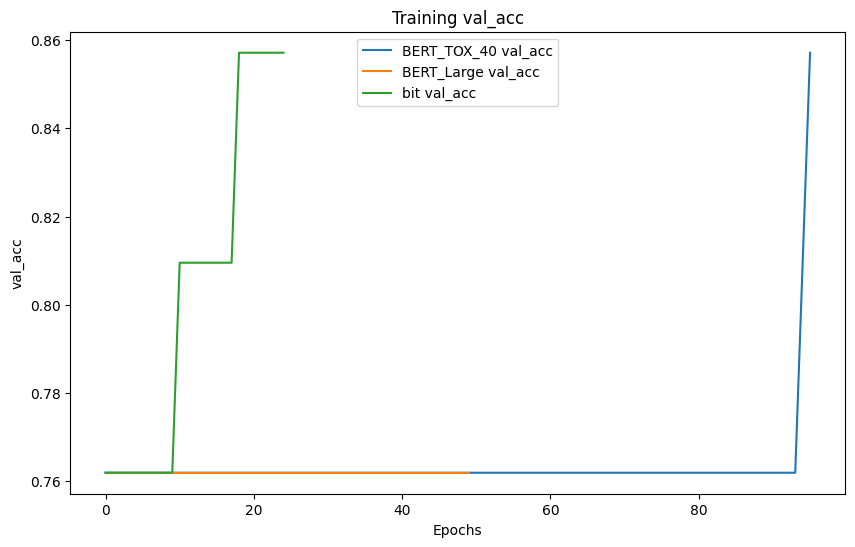

Tox :  DILI


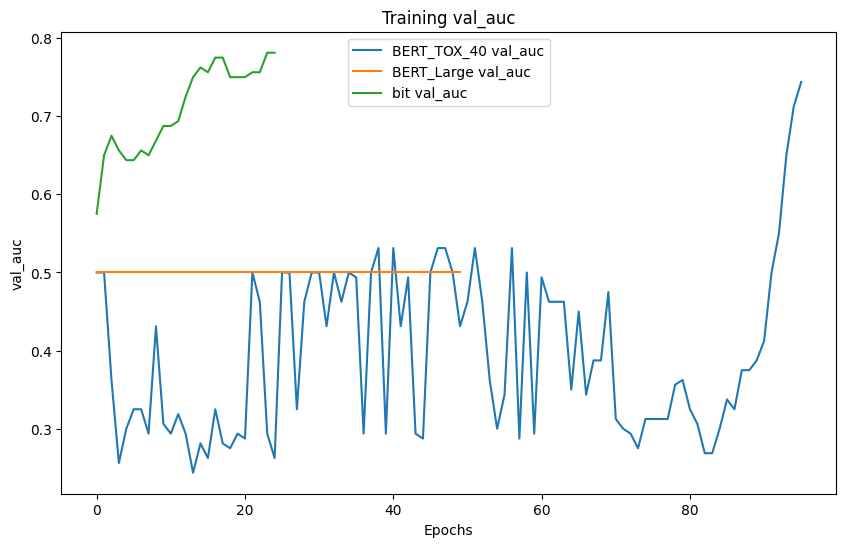

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_104 (Dense)           (None, 250)               512250    
                                                                 
 dropout_48 (Dropout)        (None, 250)               0         
                                                                 
 dense_105 (Dense)           (None, 40)                10040     
                                                                 
 dropout_49 (Dropout)        (None, 40)                0         
                                                                 
 dense_106 (Dense)           (None, 10)                410       
                                                                 
 dropout_50 (Dropout)        (None, 10)                0  

Found local copy...
Loading...
Done!


Deleted sentences : 498
Sentences :  169
['<unknown1>', '<start>', 'CC', '=C(C)', 'C', '=O', '<end>']
Epoch 1/300
5/5 [==============================] - 8s 390ms/step - loss: 0.6942 - acc: 0.7111 - auc: 0.6784 - val_loss: 0.6990 - val_acc: 0.7353 - val_auc: 0.5911 - lr: 1.0000e-06
Epoch 2/300
5/5 [==============================] - 1s 186ms/step - loss: 0.6819 - acc: 0.7407 - auc: 0.5025 - val_loss: 0.6979 - val_acc: 0.7353 - val_auc: 0.4089 - lr: 2.0000e-06
Epoch 3/300
5/5 [==============================] - 1s 170ms/step - loss: 0.6672 - acc: 0.7778 - auc: 0.5137 - val_loss: 0.6968 - val_acc: 0.7353 - val_auc: 0.5000 - lr: 3.0000e-06
Epoch 4/300
5/5 [==============================] - 1s 190ms/step - loss: 0.6921 - acc: 0.7407 - auc: 0.4683 - val_loss: 0.6953 - val_acc: 0.7353 - val_auc: 0.5911 - lr: 4.0000e-06
Epoch 5/300
5/5 [==============================] - 1s 164ms/step - loss: 0.6865 - acc: 0.7259 - auc: 0.4665 - val_loss: 0.6938 - val_acc: 0.7353 - val_auc: 0.5000 - lr: 5.0000e-0

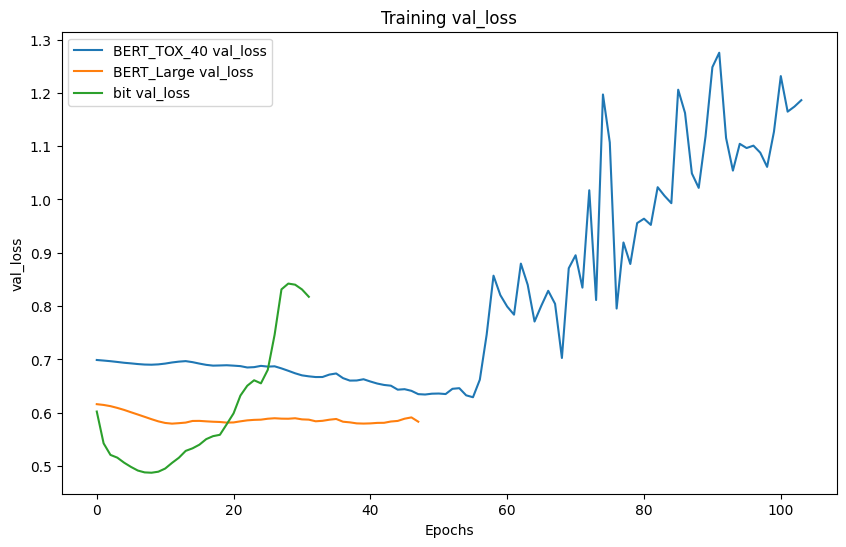

Tox :  Skin Reaction


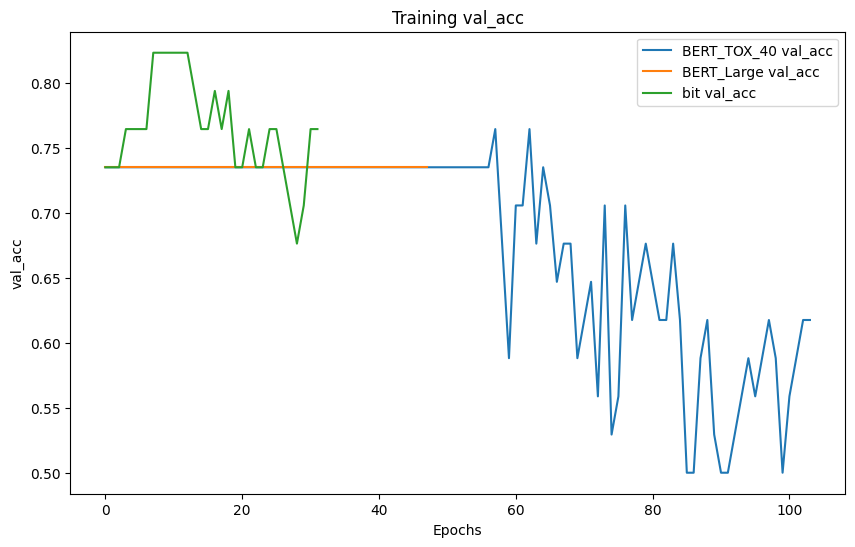

Tox :  Skin Reaction


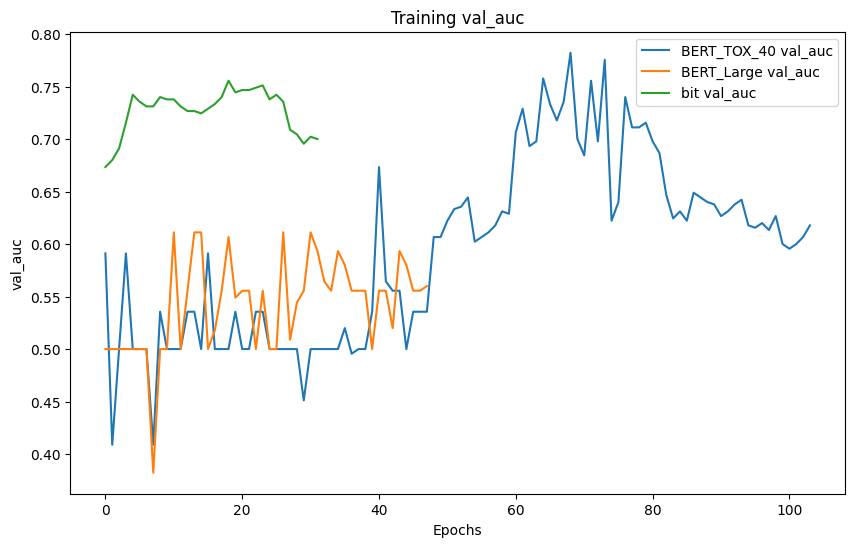

In [7]:
from Models.BERT import BERT_train
from Module.classification_SPE import ModelPlotter
from tensorflow.keras.metrics import AUC
tox = ['herg','AMES','herg_Karim','DILI','Skin Reaction']
auc = AUC()

for t in tox:
    import tensorflow as tf
    from tensorflow.keras.layers import MaxPool2D
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Input
    from tensorflow.keras.layers import Flatten,Dense
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    inputs = Input(shape=(2048,),name='input')
    outputs = Dense(250,activation = 'relu')(inputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(40,activation = 'relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(10,activation = 'relu')(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(1,activation = 'sigmoid')(outputs)

    model_NN = Model(inputs= [inputs], outputs=[outputs])
    model_NN.summary()
    model_NN.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])



    BERT_model = BERT_train("./BERT/SmiletoPE/Fine_tunned/ALL_TOX.h5",3500)
    BERT_model.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])
    BERT_model1 = BERT_train("./BERT/SmiletoPE/L_model_weights.h5",3500)
    BERT_model1.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])
    
    
    models = {'BERT_TOX_40':BERT_model,'BERT_Large':BERT_model1,'bit':model_NN}
    train,tox_info= Tox(name = t).get_data(format = 'DeepPurpose')
    
    Model_analyze = ModelPlotter(models,train,tox_info,[callback,reduce_lr,custom_callback],config = {'Tox':'ALL_TOX'})
    Model_analyze.model_fitting()

    test_list = ['loss','acc','val_acc','val_auc_1']
    for test in BERT_model.history.history.keys():
        try:
            if test[:3] == 'val':
                print('Tox : ',t)
                Model_analyze.plot_training_history([test])
                plt.show()
        except:
            continue